# Using the ASE calculators

This tutorial demonstrates how to use the [ASE](https://wiki.fysik.dtu.dk/ase/) calculators for neuroevolution potentials (NEP), which allow one to calculate energies, forces and stresses for an atomic configuration, specified in the form of an [Atoms object](https://wiki.fysik.dtu.dk/ase/ase/atoms.html).
This enables one to programmatically calculate properties that would otherwise require writing a large number of GPUMD input files and potentially tedious extraction of the results.

`calorine` provides two different ASE calculators for NEP calculations, one that uses the GPU implementation and one that uses the CPU implementation of NEP.
For smaller calculations the CPU calculators is usually more performant.
For very large simulations and for comparison the GPU calculator can be useful as well.

## CPU-based calculator

### Basic usage

First we define an atomic structure in the form of an [Atoms object](https://wiki.fysik.dtu.dk/ase/ase/atoms.html).
Next we create a calculator instance by specifying the path to a NEP model file in [nep.txt format](https://gpumd.zheyongfan.org/index.php/The_output_files_for_the_nep_executable#The_nep.txt_file).
In this tutorial, we use a [NEP3 model for PbTe](https://gitlab.com/brucefan1983/nep-data/-/tree/main/PbTe).
Finally, we attach the calculator to the `Atoms` object.

In [1]:
from ase.build import bulk
from calorine.calculators import CPUNEP

structure = bulk('PbTe', crystalstructure='rocksalt', a=6.7)
calc = CPUNEP('PbTe_NEP3.txt')
structure.calc = calc

Now, we can readily calculate energies, forces and stresses.

In [2]:
print('Energy (eV):', structure.get_potential_energy())
print('Forces (eV/Å):\n', structure.get_forces())
print('Stress (GPa):\n', structure.get_stress())

Energy (eV): -7.681070759348718
Forces (eV/Å):
 [[ 2.70616862e-16  2.85239922e-17 -1.16068684e-16]
 [-2.70616862e-16 -2.85239922e-17  1.16068684e-16]]
Stress (GPa):
 [ 4.82127071e-03  4.82127071e-03  4.82127071e-03  8.90760229e-19
 -2.20443216e-18  1.01009982e-17]


### Calculate energy-volume curve

To demonstrate the capabilities of the ASE calculator, we will now calculate an energy-volume curve with the PbTe potential.

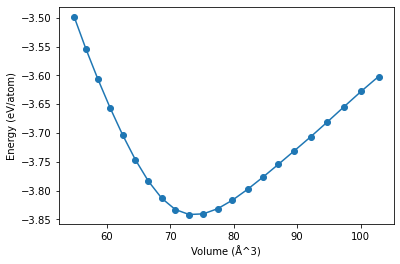

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

energies = []
volumes = []

structure_copy = structure.copy()
original_cell = structure.cell.copy()

structure_copy.calc = calc

for scale in np.arange(0.9, 1.11, 0.01):
    structure_copy.set_cell(scale * original_cell, scale_atoms=True)
    volumes.append(structure_copy.get_volume())
    energies.append(structure_copy.get_potential_energy() / len(structure_copy))

fig, ax = plt.subplots()
ax.plot(volumes, energies, '-o')
ax.set_xlabel('Volume (Å^3)')
ax.set_ylabel('Energy (eV/atom)');

## GPU-based calculator

The basic usage of the `GPUNEP` calculator class is completely analoguous to the `CPUNEP` calculator.
We create an atomic structure and attach the calculator object.

In [4]:
from calorine.calculators import GPUNEP

structure = bulk('PbTe', crystalstructure='rocksalt', a=6.7)
calc = GPUNEP('PbTe_NEP3.txt')
structure.calc = calc

Afterwards we can readily obtain energies, forces, and stresses.

In [5]:
print('Energy (eV):', structure.get_potential_energy())
print('Forces (eV/Å):\n', structure.get_forces())
print('Stresses (eV/Å^3):\n', structure.get_stress())

Energy (eV): -7.6810722351
Forces (eV/Å):
 [[-4.00012e-08 -4.61735e-08 -3.31625e-08]
 [ 4.00012e-08  4.61735e-08  3.31625e-08]]
Stresses (eV/Å^3):
 [ 4.82120785e-03  4.82120666e-03  4.82120760e-03 -1.29963668e-09
 -1.42977897e-09 -1.71918525e-09]


### Temporary and specified directories

Under the hood, the `GPUNEP` calculator creates a directory and writes the input files necessary to run GPUMD.
By default, this is done in temporary directories that are automatically removed once the calculations has finished.
It is also possible to run in a user-specified directory that will be kept after the calculations finish.
This is especially useful when running molecular dynamics simulations (see below).

In [6]:
calc.set_directory('my_directory')
structure.get_potential_energy()

-7.6810722351

After this is run, there should be a new directory, `my_directory`, in which input and output files from GPUMD are available.
This can be useful for debugging.

### Running custom molecular dynamics simulations
To take advantage of the Python workflow as well as raw speed of the GPU accelerated NEP implementation, the `GPUNEP` calculator contains a convenience function for running customized molecular dynamics simulations.
This should typically be done in a specified directory.
The [parameters of the run.in file](https://gpumd.zheyongfan.org/index.php/Main_Page#Inputs_for_the_src.2Fgpumd_executable) are specified as a list of tuples with two elements, the first being the keyword name and the second any arguments to that keyword.

In [7]:
calc.set_directory('my_md_simulation')
supercell = structure.repeat(5)
structure.calc = calc
parameters = [('velocity', 300),
              ('dump_thermo', 100),
              ('dump_position', 100),
              ('ensemble', ('nvt_lan', 300, 300, 100)),
              ('run', 1000)]
calc.run_custom_md(parameters)

Once this is run, the results are available in the folder `my_md_simulations`.